In [3]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
roman_path = '/hpc/group/cosmology/OpenUniverse2024'
sn_path = roman_path + '/roman_rubin_cats_v1.1.2_faint/'
import requests
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from matplotlib import pyplot as plt
from roman_imsim.utils import roman_utils
from roman_imsim import *
import astropy.table as tb
import warnings 
from astropy.utils.exceptions import AstropyWarning
from erfa import ErfaWarning
warnings.simplefilter('ignore', category=AstropyWarning)
warnings.filterwarnings("ignore", category=ErfaWarning)
import scipy.sparse as sp 
from scipy.linalg import block_diag, lstsq
from numpy.linalg import LinAlgError
from astropy.nddata import Cutout2D
from coord import *
import requests
from astropy.table import Table
import os
import scipy
from AllASPFuncs import *


917 Potential Candidates
-----------------------
Dialing up the photons 1 at a time
27.63367435233032 zpt
realized flux 22135    16977.0
Name: realized_flux, dtype: float64
measured flux [16630.59700983]
-----------------------
Dialing up the photons 1 at a time
27.597032121020195 zpt
realized flux 22175    16784.0
Name: realized_flux, dtype: float64
measured flux [17011.18630876]
-----------------------
Dialing up the photons 1 at a time
27.655797626691033 zpt
realized flux 21452    16922.0
Name: realized_flux, dtype: float64
measured flux [17098.08973108]
-----------------------
Dialing up the photons 1 at a time
27.61268412018935 zpt
realized flux 22971    17175.0
Name: realized_flux, dtype: float64
measured flux [17929.32876691]
924 Potential Candidates
-----------------------
Dialing up the photons 1 at a time
27.597032121020195 zpt
realized flux 22164    4547.0
Name: realized_flux, dtype: float64
measured flux [4713.7450068]
-----------------------
Dialing up the photons 1 at a t

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


27.587881837350075 zpt
realized flux 23122    1123.0
Name: realized_flux, dtype: float64
measured flux [1094.49832657]


<Figure size 500x2500 with 0 Axes>

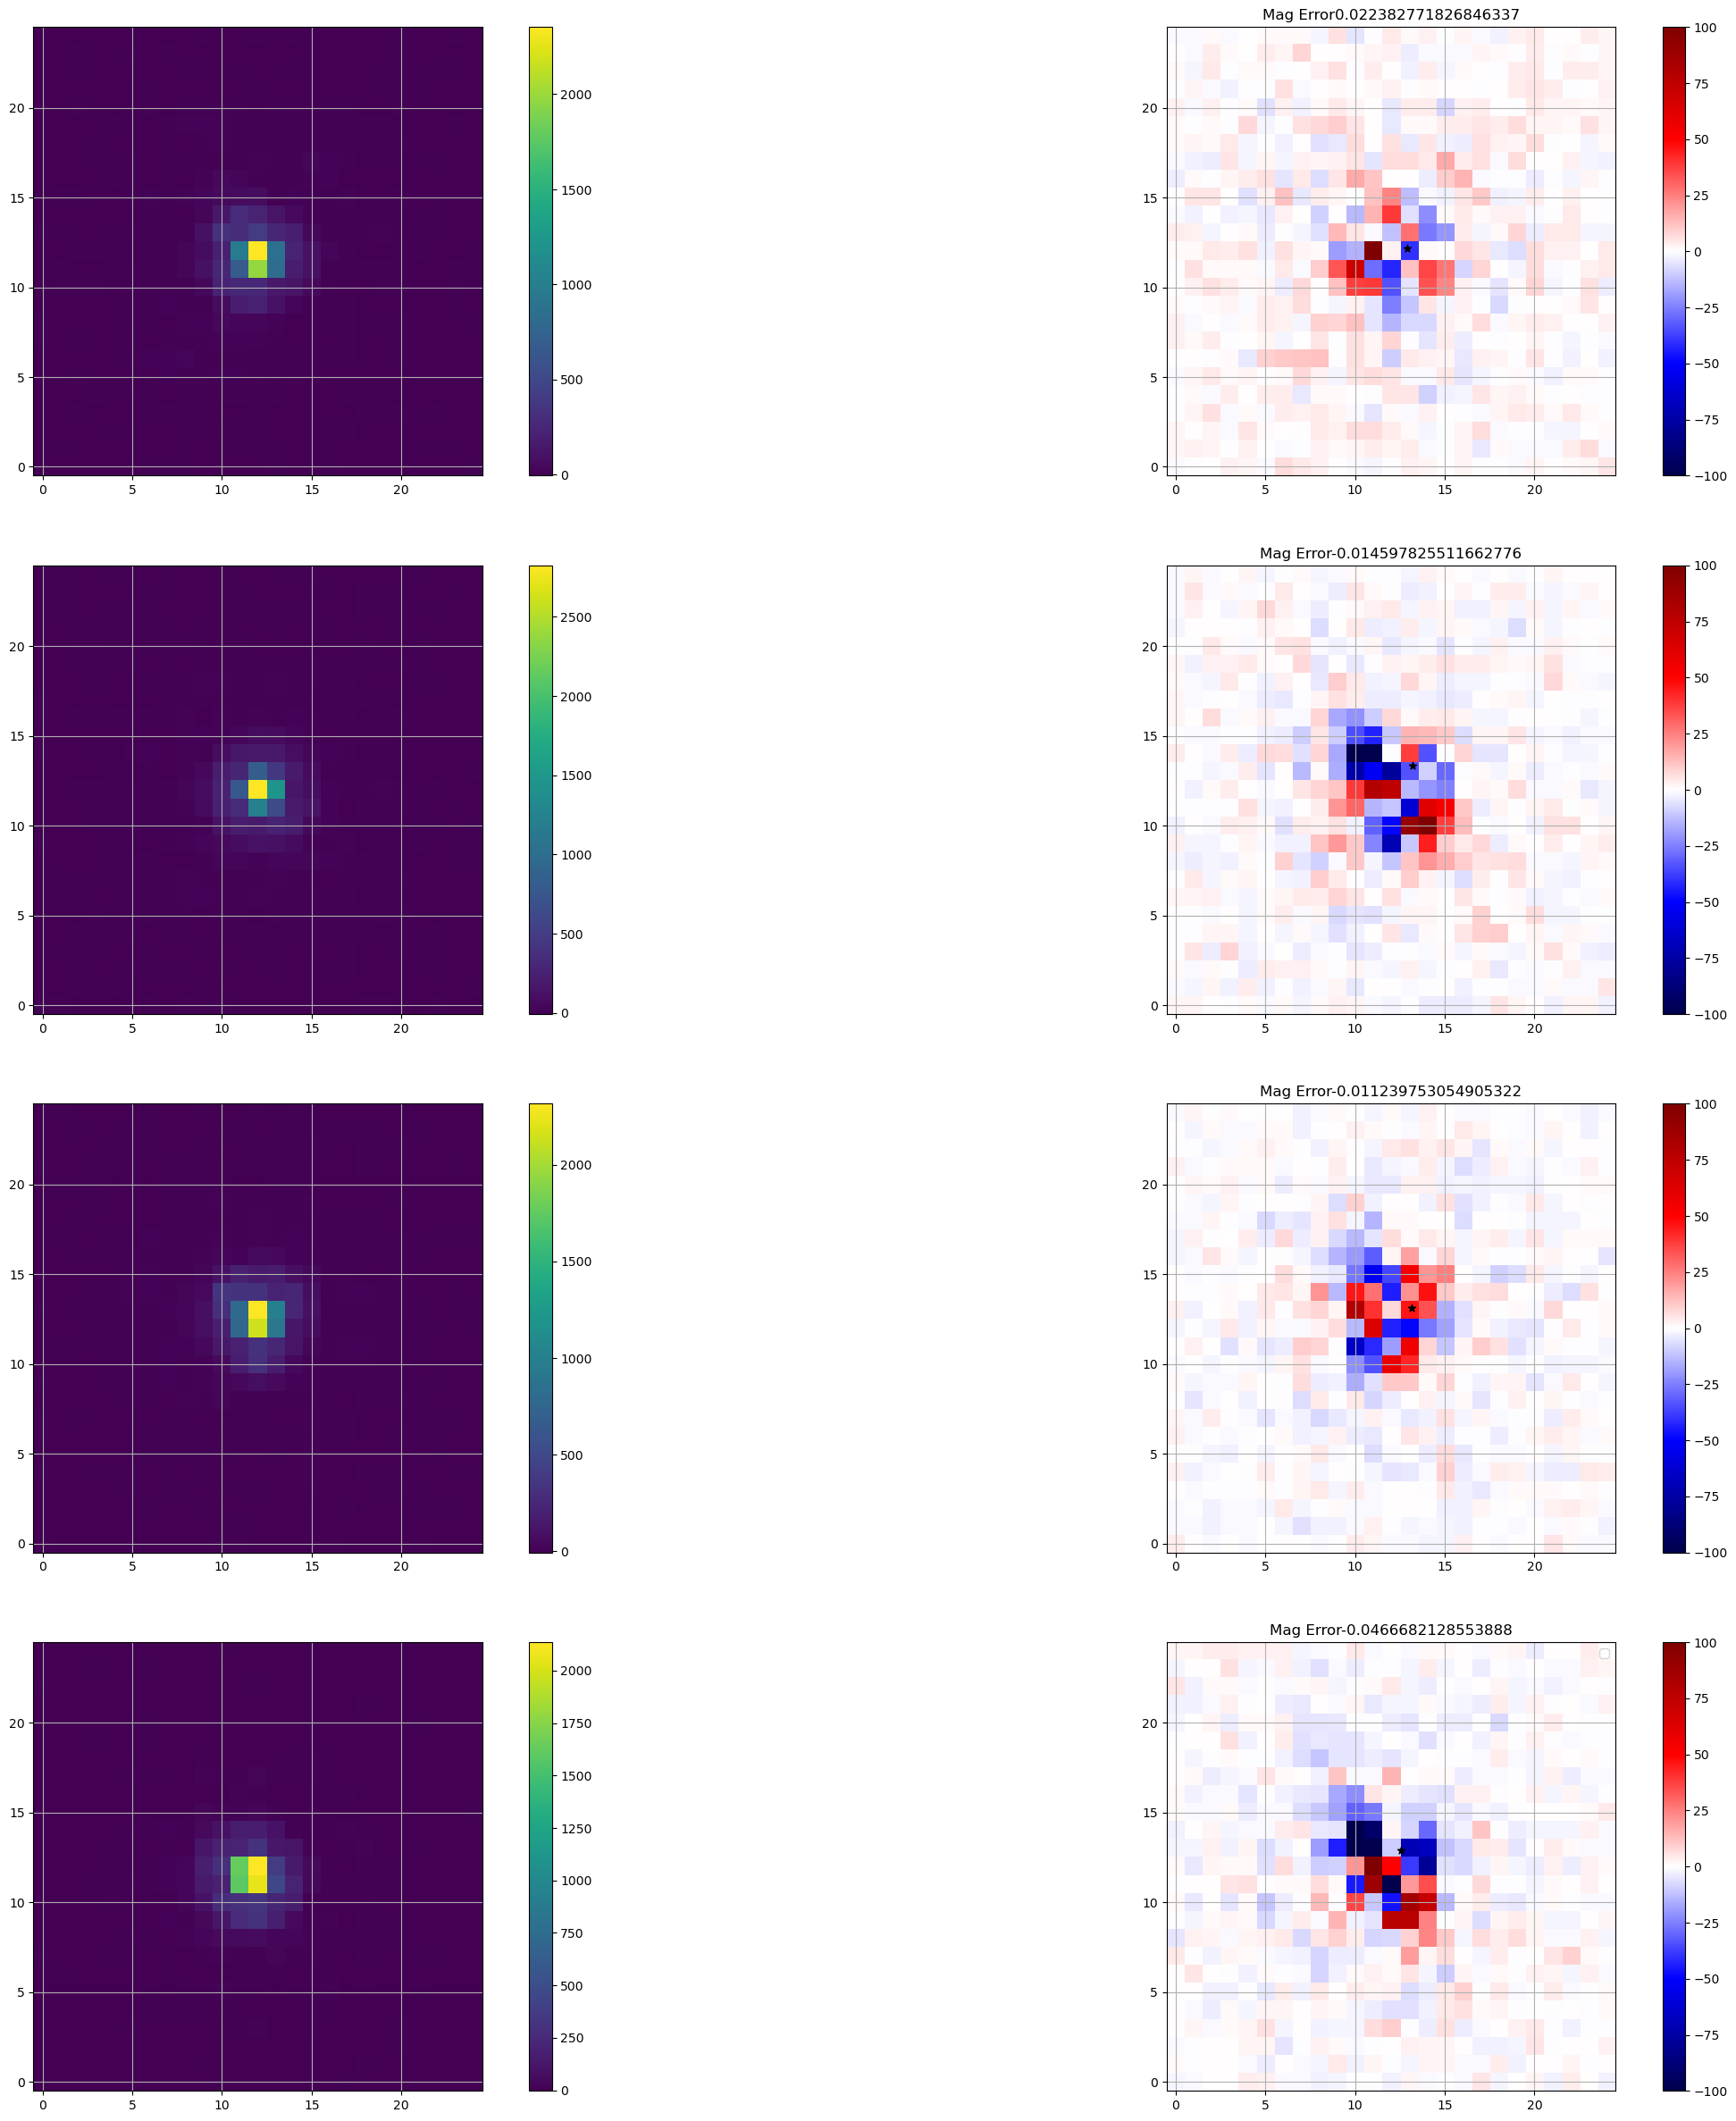

In [24]:
#PSF Photometry example.

sn_path = '/cwork/mat90/RomanDESC_sims_2024/roman_rubin_cats_v1.1.2_faint/'
plt.figure(figsize = (5,25))
band = 'F184'
pointing, SCA = 13021, 15
cat = pd.read_csv(roman_path+f'/RomanTDS/truth/{band}/{pointing}/Roman_TDS_index_{band}_{pointing}_{SCA}.txt',\
                                sep="\s+", skiprows = 1,
                                names = ['object_id', 'ra', 'dec', 'x', 'y', 'realized_flux', 'flux', 'mag', 'obj_type'])
cat_star = cat.loc[cat['obj_type'] == 'star']
IDs = []
ras = []
decs = []
#Fetch some stars at various magnitudes.
for i in np.linspace(4,7,3):
    cat_close = cat_star.loc[np.isclose(cat_star['mag'], i, atol = 0.1)]
    IDs.append(cat_close.object_id.values[0])
    ras.append(cat_close.ra.values[0])
    decs.append(cat_close.dec.values[0])


results_dict = {}

size = 25  
nbg = -1
plt.figure(figsize = (30,30))
#Loop over the stars
for i, ID in enumerate(IDs):
    ra = ras[i]
    dec = decs[i]
    start = 0
    end = 10**999
    p = pointing
    s = SCA
    peak = 0

    server_url = 'https://roman-desc-simdex.lbl.gov'
    req = requests.Session()
    result = req.post( f'{server_url}/findromanimages/containing=({ra},{dec})' )
    if result.status_code != 200:
        raise RuntimeError( f"Got status code {result.status_code}\n{result.text}" )

    res = pd.DataFrame(result.json())[['filter','pointing','sca', 'mjd']]
    res.rename(columns = {'mjd':'date', 'pointing': 'Pointing', 'sca': 'SCA'}, inplace = True)
    print(res.shape[0], 'Potential Candidates')
    res = res.loc[res['filter'] == band]

    realized_flux = []
    measured_flux = []
    zpts = []
    k = 0
    #Loop over each image
    for index, row in res.iterrows():
        print('-----------------------')
        p = row['Pointing']
        s = row['SCA']
        image = fits.open(roman_path + f'/RomanTDS/images/truth/{band}/{p}/Roman_TDS_truth_{band}_{p}_{s}.fits.gz')
        scawcs = WCS(image[0].header)
        x,y = scawcs.world_to_pixel(SkyCoord(ra = ra*u.degree, dec = dec*u.degree))
        if x < 25 or x > 2*2048 - 25 or y < 25 or y > 2*2048 - 25:
            print('Out of bounds')
            continue
        cutout = Cutout2D(image[0].data, SkyCoord(ra = ra*u.degree, dec = dec*u.degree), size, wcs = scawcs)
        cutoutwcs = galsim.AstropyWCS(wcs = cutout.wcs)
        x_center, y_center = cutoutwcs.toImage(ra, dec, units = 'deg')

        #Build the PSF using galsim
        psf = construct_psf_source(x, y, pointing, SCA, stampsize=25,  x_center = x_center, y_center = y_center)
        #fit the psf to the image
        im = cutout.data
        im = im.flatten()
        psf = psf.flatten()
        psf = psf.reshape(-1,1)
        lsqr = sp.linalg.lsqr(psf, im, atol = 1e-12, btol = 1e-12, iter_lim=300000, conlim = 1e10)
    
        cat = pd.read_csv(roman_path+f'/RomanTDS/truth/{band}/{p}/Roman_TDS_index_{band}_{p}_{s}.txt',\
                                sep="\s+", skiprows = 1,
                                names = ['object_id', 'ra', 'dec', 'x', 'y', 'realized_flux', 'flux', 'mag', 'obj_type'])

        cat_star = cat.loc[cat['obj_type'] == 'star']
        logflux = -2.5*np.log10(cat_star['flux'])
        exptime = image[0].header['EXPTIME']
        area_eff = roman.collecting_area
        galsim_zp = roman.getBandpasses()[band].zeropoint
        truthmag = -2.5*np.log10(cat['flux']) + 2.5*np.log10(exptime*area_eff) + galsim_zp
        mag = cat_star['mag']
        zpt = np.nanmedian(truthmag)
        print(zpt, 'zpt')
        zpts.append(zpt)
        cat = cat.loc[cat['object_id'] == ID]
        print('realized flux', cat['realized_flux'])
        print('measured flux', lsqr[0])
        

        realized_flux.append(cat['realized_flux'].values[0])
        measured_flux.append(lsqr[0][0])
        if i == 0:
            plt.subplot(4,2,2*k+1)
            plt.imshow(im.reshape(25,25), origin = 'lower')
            plt.grid('True')
            plt.colorbar()
            plt.subplot(4,2,2*k + 2)
            k+=1
            plt.grid('True')
            plt.imshow(im.reshape(25,25) - psf.reshape(25,25) * lsqr[0][0], origin = 'lower', cmap = 'seismic', vmax = 100, vmin = -100)
            plt.colorbar()
            plt.scatter(x_ref, y_ref, color = 'k', marker = '*')
            plt.title('Mag Error' + str(-2.5 * np.log10(lsqr[0][0])- -2.5*np.log10(cat['realized_flux'].values[0])) )

        if len(realized_flux) == 4:  #Capping at 4 Images for brevity
            break

        results_dict[ID] = {'realized_flux': realized_flux, 'measured_flux': measured_flux, 'zpts': zpts}

        
plt.legend()
    

STD: 0.02444514190406649
mean: 0.01253075489877764
ZPT: [27.63367435233032, 27.597032121020195, 27.655797626691033, 27.61268412018935]
Measured: [16630.59700982717, 17011.186308755117, 17098.089731078588, 17929.328766910152]
Realized: [16977.0, 16784.0, 16922.0, 17175.0]
STD: 0.014417005140449596
mean: 0.016620416449126818
ZPT: [27.597032121020195, 27.576451322869843, 27.587881837350075, 27.59811200840697]
Measured: [4713.7450067978225, 4588.336804085223, 4473.815542613306, 4530.200799075025]
Realized: [4547.0, 4508.0, 4464.0, 4506.0]
STD: 0.027268234911212195
mean: 0.011120435664703221
ZPT: [27.533757667400266, 27.637947127873026, 27.576451322869843, 27.587881837350075]
Measured: [1180.2968518177604, 1187.6328386095417, 1150.4636244669134, 1094.498326567619]
Realized: [1130.0, 1165.0, 1146.0, 1123.0]


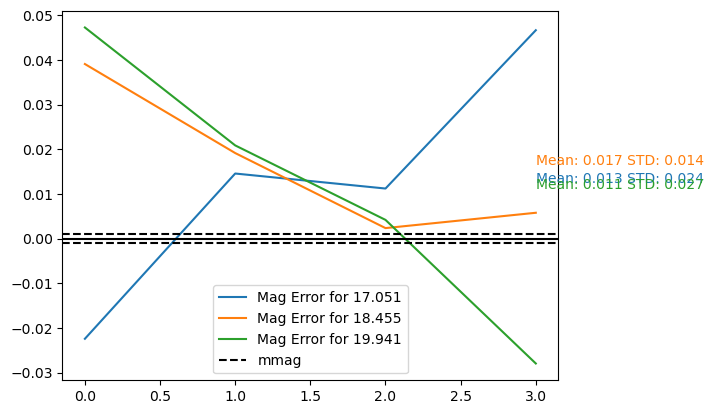

In [25]:


for i,ID in enumerate(list(results_dict.keys())):
    realized_flux = results_dict[ID]['realized_flux']
    measured_flux = results_dict[ID]['measured_flux']
    zpts = results_dict[ID]['zpts']
    std = np.std(-2.5*np.log10(np.array(realized_flux)) - (-2.5*np.log10(np.array(measured_flux))))
    mean = np.mean(-2.5*np.log10(np.array(realized_flux)) - (-2.5*np.log10(np.array(measured_flux))))
    meanmag = np.mean(-2.5*np.log10(np.array(realized_flux)) + np.array(zpts))
    print('STD:', std)
    print('mean:', mean)
    print('ZPT:', zpts)
    print('Measured:', measured_flux)
    print('Realized:', realized_flux)
    #plt.plot(-2.5*np.log10(np.array(realized_flux)) + np.array(zpts), color = 'C' + str(i), ls = '--')
    plt.plot(-2.5*np.log10(np.array(realized_flux)) - (-2.5*np.log10(np.array(measured_flux))), color = 'C' + str(i), label = f'Mag Error for {np.round(meanmag,3)}')
    plt.text(np.size(realized_flux)-1, mean, 'Mean: ' + str(np.round(mean,3)) + ' STD: ' + str(np.round(std,3)), color = 'C' + str(i)) 

plt.axhline(0, color = 'k')
plt.axhline(0.001, color = 'k', ls = '--')
plt.axhline(-0.001, color = 'k', ls = '--', label = 'mmag')
plt.legend()
